In [1]:
import enum
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from matplotlib.cm import ScalarMappable
import eurostat

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath(".."))

from data_analysis.eurostat_population_utils import get_eurostat_population_data 
from data_analysis.eurostat_crf_utils import *
from data_analysis.eurostat_geo import *

TOHLE TVOŘÍM: https://faktaoklimatu.cz/infografiky/emise-eu-na-osobu

## 1) Set year and load data

In [2]:
# Year we want to visualize
YEAR = 2016

In [3]:
# fetch emission data using 'get_eurostat_crf_data_for_code' function
df_emis = get_eurostat_crf_data_for_code(
    "TOTX4_MEMONIA", YEAR).rename(columns={'value': 'MtCO2eq'})

In [4]:
# fetch demographic data using 'get_eurostat_population_data' function
df_demo = get_eurostat_population_data(
    YEAR).rename(columns={'value': 'population'})

In [5]:
# Merge the data frames on select only EU27 countries.
df = df_emis.merge(df_demo, on='geo')
df = df.loc[df.index.isin([geo.value for geo in eu27_geo_dict.keys()])]
df['country'] = eu27_geo_dict.values()

In [6]:
df['population_(mil)'] = (df['population'] / 1000000)
df['em_per_capita'] = (df['MtCO2eq'] * 1000000) / df['population']
df['total'] = (df['population_(mil)'] * df['em_per_capita'])

In [7]:
df.head()

,MtCO2eq,population,country,population_(mil),em_per_capita,total
geo,,,,,,
AT,82.16347,8700471.0,Rakousko,8.700471,9.443566,82.16347
BE,121.82931,11311117.0,Belgie,11.311117,10.770759,121.82931
BG,58.48840,7153784.0,Bulharsko,7.153784,8.175869,58.48840
CY,9.74565,848319.0,Kypr,0.848319,11.488190,9.74565
CZ,131.84903,10553843.0,Česko,10.553843,12.492988,131.84903


### TODO
- uprav pozice tak, aby před prvním barem nebyla mezera
-- tohle furt nevim jak udělat
- popisky os grafu: CO2 - tu '2' do nižšího indexu
- popisné texty pod graf

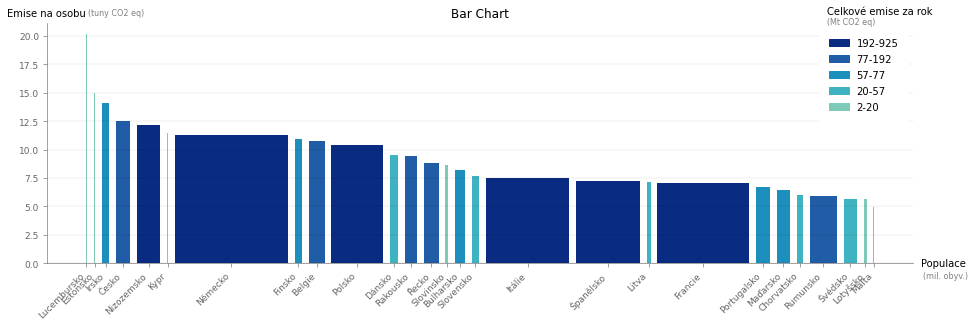

In [8]:
# Set colors and color intervals
color_intervals = [20, 40, 60, 80] # Change the color groups in the chart by changing 'intervals' here
colors = ['#3fb3c2', '#1c8fbd', '#215ca6', '#0a2b82', '#7dcab8']

# Sort the DataFrame based on the 'em_per_capita' column in descending order
df_sorted = df.sort_values(by='em_per_capita', ascending = False)

# Calculate the widths for each bar based on the sorted total values
widths = df_sorted['population_(mil)'].values.tolist()

# COMPUTE POSITIONS ON X AX
# Set the gap between bars
gap = 5
# Each position is the previous one + half of the widths of the neighbouring columns + the gap
positions = [widths[0]/2 + gap]
for i in range(len(widths) - 1):
    positions.append(positions[i] + widths[i]/2 + widths[i+1]/2 + gap)
# Find the minimum value in the list
min_value = min(positions)
# Subtract the minimum value from each element in the list
positions = [value - min_value for value in positions]

# CREATE COLOR INTERVALS  
# Create df_sorted_total which is sorted by 'total' values to correctly add the colors
df_sorted_total = df.sort_values(by='total', ascending = False)

# Determine the color for each 'total' value
color_mapping = np.digitize(df_sorted_total['total'], bins=np.percentile(df_sorted_total['total'], color_intervals))

# Create a DataFrame for colors
df_for_colors = pd.DataFrame({'total': df_sorted_total['total'], 'colors': [colors[i-1] for i in color_mapping]}) 
df_sorted['colors'] = df_for_colors['colors']   
        
# SET CHART PROPRETIES 
# Set the size of the chart frame
plt.figure(figsize=(14,4))

# Create a bar chart with sorted, spaced, and no overlap bars
bars = plt.bar(positions, df_sorted['em_per_capita'], width=widths, color=df_sorted['colors'], edgecolor=None)

# Adding labels and title
plt.xlabel('Populace')
plt.ylabel('Emise na osobu', rotation=0)
plt.title('Bar Chart')

# Set x-axis ticks to the positions of the bars
plt.xticks(positions, df_sorted['country'], rotation=45, ha='right')  

# Remove vertical grid lines
plt.gca().xaxis.grid(False)

# Move ax x label
plt.gca().xaxis.set_label_coords(1.035, 0.02)
plt.gca().yaxis.set_label_coords(0.0, 1.02)

# Add texts
plt.text(0.9,21.8, f'(tuny CO2 eq)', size = 8, color ='grey')
plt.text(610,-1.3, f'(mil. obyv.)', size = 8, color ='grey')
plt.text(540,21.9, f'Celkové emise za rok', size = 10, color ='black')
plt.text(540,21, f'(Mt CO2 eq)', size = 8, color ='grey')

# ADD LEGEND
# Define intervals based on the array
array = list(np.percentile(df_sorted_total['total'], color_intervals))
intervals = [min(df_sorted_total['total'])] + array + [max(df_sorted_total['total'])]
intervals = [[intervals[i], intervals[i+1]] for i in range(len(intervals)-1)]

# Create proxy artists and labels for legend
num_intervals = 5
patches = [mpatches.Patch(color=colors[i-1], alpha=1, label=f'{intervals[i][0]:.0f}-{intervals[i][1]:.0f}') for i in range(num_intervals)]
patches = patches[::-1] # sort descending

# Add the legend with intervals
plt.legend(handles=patches, facecolor='white')

# DISPLAY THE CHART
plt.show()

## X) Texts 

In [9]:
df.head(2)

,MtCO2eq,population,country,population_(mil),em_per_capita,total
geo,,,,,,
AT,82.16347,8700471.0,Rakousko,8.700471,9.443566,82.16347
BE,121.82931,11311117.0,Belgie,11.311117,10.770759,121.82931


In [10]:
df_sorted.head(2)

,MtCO2eq,population,country,population_(mil),em_per_capita,total,colors
geo,,,,,,,
LU,11.61019,576249.0,Lucembursko,0.576249,20.147870,11.61019,#7dcab8
EE,19.74207,1315944.0,Estonsko,1.315944,15.002211,19.74207,#7dcab8


In [11]:
# Find the country which creates most CO2eq emissions in EU
df_sorted_MtCO2eq = df.sort_values(by='MtCO2eq', ascending = False)
country_most_MtCO2eq = df_sorted_MtCO2eq.iloc[0]['country']

# Find the country whith the biggest population
df_sorted_population = df.sort_values(by='population', ascending = False)
country_top_popul = df_sorted_population.iloc[0]['country']

# Find the country whith the biggest emission per capita
country_most_em_per_capita = df_sorted.iloc[0]['country'] # country
top_em_per_capita_value = df_sorted.iloc[0]['em_per_capita'] # value

# compute text variables
em_na_os_EU = (sum(df_sorted['total'])/sum(df_sorted['population']))*1000000  # emissions per person EU in tons

In [12]:
# # Print backing texts
print(f'''
Průměrné emise na osobu v Evropské unii za rok {YEAR} jsou {em_na_os_EU:.1f} tun CO2eq.
''')

print(f'''
Největším producentem skleníkových plynů v Evropské unii je v absolutním srovnání {country_most_MtCO2eq}. {country_top_popul} je také nejlidnatějším státem EU.
''') # umí se rozbít if jiný nejlidnatější stát EU... ale druhá Francie na Německo ztrácí víc než 10 mil lidí.

print(f'''
V přepočtu na obyvatele vypouští nejvíce skleníkových plynů {country_most_em_per_capita} ({top_em_per_capita_value:.0f}t CO2eq ročně). 
''')

print(f'''
blablabla
''')


Průměrné emise na osobu v Evropské unii za rok 2016 jsou 8.8 tun CO2eq.


Největším producentem skleníkových plynů v Evropské unii je v absolutním srovnání Německo. Německo je také nejlidnatějším státem EU.


V přepočtu na obyvatele vypouští nejvíce skleníkových plynů Lucembursko (20t CO2eq ročně). 


blablabla



### vzor
    Průměrné emise na osobu v Evropské unii jsou 8,7 tun CO2eq. Oproti tomu světový průměr emisí na osobu je 6,51 tun CO2eq na rok. Pokud by každý člověk na zemi vypouštěl tolik emisí jako průměrný obyvatel Evropské unie, vzrostly by celosvětové emise o více než 30 %. Srovnání světových regionů a vybraných států v obdobném formátu ukazuje infografika Emise světových regionů přepočtené na osobu.
    
    Největším producentem skleníkových plynů v Evropské unii je v absolutním srovnání Německo, které je zároveň také nejlidnatějším státem unie.
    
    V přepočtu na obyvatele vypouští nejvíce skleníkových plynů Lucembursko (20 t CO2eq ročně), kde více než 60 % emisí pochází z dopravy, dle platformy Votum Klima je to způsobené nafto-benzínovým turismem. Druhé Estonsko (15 t CO2eq) a čtvrtá Česká republika (12,4 CO2eq) mají vysoké emise kvůli energetickému mixu založenému na uhlí a třetí Irsko (13,6 t CO2eq) kvůli zemědělství. Detailnější analýzu emisí podle jednotlivých sektorů lze nalézt ve zpracovaném datasetu.
    
    Naopak nejnižší emise na osobu má z Evropských států Malta (5,1 t CO2eq), následovaná Švédskem (5,6 t CO2eq). Zároveň životní úroveň ve Švédsku je téměř o 40 % vyšší než v České republice, snižování emisí tedy nemusí být překážkou zvyšování životní úrovně obyvatel. Švédsko má zavedenou uhlíkovou daň již od roku 1991, dnes nejvyšší z celého světa – 127 $ / t CO2. Ve zprávě z roku 2019 Mezinárodní měnový fond vysvětluje, proč je uhlíková daň nejefektivnějším opatřením na snižování emisí skleníkových plynů, jak zobrazuje také související infografika o mitigačních opatřeních.
